## Merging Data Sets: Uncovering Temperature Correlations in Chicago Bus Ridership

Lately I've been having fun exploring data sets from the [Chicago open data portal](https://data.cityofchicago.org/). I think it's great that the city is providing access to government data and encouraging people to explore it. One of the first data sets I looked at involved ridership on the public [buses](http://grammarist.com/spelling/buses-busses/). It turns out it's very well documented... you can look at how many people rode buses on each route every day for the past several years. I went and downloaded a simple csv file [here](https://data.cityofchicago.org/Transportation/CTA-Ridership-Bus-Routes-Daily-Totals-by-Route/jyb9-n7fm) and began exploring it. If you're curious yourself, [here is a link to similar data](https://data.cityofchicago.org/Transportation/CTA-List-of-CTA-Datasets/pnau-cf66) that might be useful. There is even an API for stop-by-stop data for each bus that live-updates which I haven't tried out yet. Here's an interesting [blog post](https://dssg.uchicago.edu/2013/08/02/cta-why-bus-crowding-happens-and-how-data-can-help/) I found about it which describes a project done by someone in the [Data Science for Social Good](https://dssg.uchicago.edu/) fellowship. It's an interesting read, if you too care about the public bus system in the City of Chicago!

After exploring of the dataset and training a few basic models to try and predict ridership, I began to wonder what other external features might be useful for such a prediction. Maybe I could scrape some information about public gatherings like sporting events to predict overcrowding on routes leading to stadiums? Perhaps some buses will have fewer than average riders on public school holidays? I decided to try and determine if people ride the bus more when it's nice outside. If you're looking for me and it's -20F out (thanks, polar vortex), don't bother checking buses because I'll absolutely be at home.

In this blog post, I will demonstrate how to clean and merge together two data sets from different sources. Here I will be combining historical bus riderships per day with weather data per day. I'll use timestamps to join the tables together and I'll try to search for correlations within the two data sets.

#### The Question
Does ridership on Chicago public buses correlate with air temperature?

#### The Data
The ridership data is publicly accessible through the Chicago open data portal, and (obviously) there's a plethora of historical weather data out there to be had. I chose to get my data from the [National Oceanic and Atmospheric Administration (NOAA)](https://www.ncdc.noaa.gov/) website. You can request which features interest you (air temperature, precipitation type, precipitation amount, etc), select the date ranges and location of interest, and download the data for free. I downloaded my own csv for the Chicago area to include in this analysis.

#### The Tools
In this quick study, I'll be using numpy, matplotlib, and pandas. With the two datasets stored in pandas dataframes, there are some nice SQL-esque `join` functions that pandas offers.

#### The Analysis
The analysis in this post is quite simple. I want to compare public bus ridership on different routes with air temperature, so I'll develop a metric ($R^2$ from a linear fit for example) to determine amount of correlation. This blog post is mostly to demonstrate how to merge two data sets from different sources (ridership, and weather). That said, the results are pretty interesting, too!

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let's start by reading in the bus ridership csv file I downloaded, then doing some cleaning to prepare it to be merged with weather data.

In [2]:
myRidershipFile = 'data/CTA_-_Ridership_-_Bus_Routes_-_Daily_Totals_by_Route.csv'
df = pd.read_csv(myRidershipFile,index_col=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 701321 entries, 0 to 701320
Data columns (total 4 columns):
route      701321 non-null object
date       701321 non-null object
daytype    701321 non-null object
rides      701321 non-null int64
dtypes: int64(1), object(3)
memory usage: 26.8+ MB


The 'route' column is self explanatory, there are 182 routes and the name is stored as a string (despite many of the route names being numbers). 'daytype' indicates whether the day is a weekday, Saturday, or Sunday/Holiday ('W', 'A', or 'U' respectively). Also, the date column is a string too. Since ultimately this will be the field on which we will perform our SQL-like join with weather data, it's probably best to convert this column to an actual python datetime object... we'll use the pandas [build-in `to_datetime` function](http://pandas.pydata.org/pandas-docs/version/0.19.2/generated/pandas.to_datetime.html).

In [4]:
df['date_dt'] = pd.to_datetime(df['date'],format='%m/%d/%Y')
df['year'] = df['date_dt'].dt.year

In [5]:
#ignore
# Let's compute for each route, for each year, the average ridership

# Key = route, value = dict of { year : { daytype : (mean ridership, std ridership) } }
avg_dict = {} 

# I'm sure there's a more pandas/pythonic way to do this but I'm a plane with no wifi right now :(
grouped = df.groupby('route')
for route, subdf in grouped:
    avg_dict[route] = {}
    subgrouped = subdf.groupby('year')
    for year, subsubdf in subgrouped:
        avg_dict[route][year] = {}
        subsubgrouped = subsubdf.groupby('daytype')
        for daytype, subsubsubdf in subsubgrouped:
            theserides = subsubsubdf['rides']
            avg_dict[route][year][daytype] = ( np.mean(theserides), np.std(theserides) )

In [6]:
#ignore
# Now let's add a column to our dataframe of: for each day on a given route,
# the difference between that day's rides and the mean for that route for that year
def getAvg( route, year, daytype ):
    return float(avg_dict[route][year][daytype][0])
getAvg = np.vectorize(getAvg)

df['yearmean'] = getAvg(df['route'],df['year'],df['daytype'])
df['diff_yearmean'] = df['rides'] - df['yearmean']

In [7]:
#ignore
# To fully normalize things, what we want is for each ride, the number of standard
# deviations above (or below) the mean
def getStd( route, year, daytype ):
    return float(avg_dict[route][year][daytype][1])
getStd = np.vectorize(getStd)

# Ex: mean is 10, std is 3. if one day has 16, that is two std above
# (day - mean) / std
df['stds_yearmean'] = df['diff_yearmean'] / getStd(df['route'],df['year'],df['daytype'])

Now let's read in the NOAA weather data and clean it up a little. We need to make sure we end up with a column called 'date_dt' that holds datetime objects. Having the same column name and type as in the bus ridership dataframe is crucial for the `join` we'll be doing later.

In [8]:
myWeatherFile = 'data/832070.csv'
wdf = pd.read_csv(myWeatherFile,index_col=False)

In [9]:
wdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5778 entries, 0 to 5777
Data columns (total 9 columns):
STATION         5778 non-null object
STATION_NAME    5778 non-null object
DATE            5778 non-null int64
PRCP            5778 non-null float64
SNWD            5778 non-null float64
SNOW            5778 non-null float64
TAVG            5778 non-null int64
TMAX            5778 non-null int64
TMIN            5778 non-null int64
dtypes: float64(3), int64(4), object(2)
memory usage: 451.4+ KB


In [10]:
#ignore
# Also let's replace all column names to remove spaces
# cols = wdf.columns
# cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str, unicode)) else x)
# wdf.columns = cols


With some quick exploring, I find that the `TAVG` column (average temperature) for some reason has several years worth of -999 values in it, but `TMAX` and `TMIN` seem to look better. I'll just define my own average temperature as `TMAX+TMIN/2`. There are a few days remaining where even this temperature is undefined, so we'll throw those out too.

In [11]:
wdf['MAXMINAVG'] = (wdf['TMAX'] + wdf['TMIN']) / 2.
wdf = wdf.query('MAXMINAVG > -999')

Let's make the datetime column in the weather dataframe now. The date string in this data is annoyingly a different format, but that's no problem for the `to_datetime` function.

In [12]:
wdf['date_dt'] = pd.to_datetime(wdf['DATE'],format='%Y%m%d')

Now comes the reason you're still reading! The [pandas merge](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) between the ridership dataframe and the weather dataframe. While the weather dataframe has exactly one entry per day, the ridership dataframe has 182 entries per day (since there are that many routes). I want my merged dataframe to also have 182 entries per day, with duplicates of the weather information for that day. Also I want to throw out any ridership days that don't have matched weather days, and vice versa. The prescribed SQL join to do this is an [inner join](https://www.tutorialspoint.com/sql/sql-inner-joins.htm). In SQL lingo this join should look something like:

> SELECT * FROM df INNER JOIN wdf ON df.date_dt = wdf.date_dt

but in pandas it looks like this:

In [13]:
mergedf = df.merge(wdf, on='date_dt', how='inner')

With the `merge` completed, some quick simple plots can be made from the merged dataframe. Check this one out!

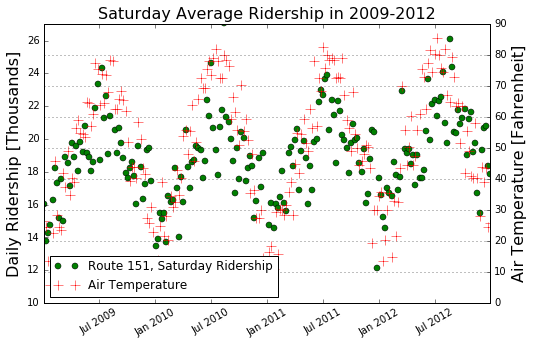

In [14]:
#ignore
myquery = 'route=="151" and daytype == "A" and year > 2008 and year < 2013'

myy1 = mergedf.query(myquery)['rides'].values / 1000.
myy2 = mergedf.query(myquery)['MAXMINAVG'].values
myx = mergedf.query(myquery)['date_dt'].values

fig, ax = plt.subplots(figsize=(8,5))
riderplot = ax.plot(myx,myy1,'go',label='Route 151, Saturday Ridership')
ax.set_ylabel('Daily Ridership [Thousands]',fontsize=16)
ax.set_ylim((10,27))
ax2 = ax.twinx()
tempplot = ax2.plot(myx,myy2,'r+',label='Air Temperature',markersize=10)
ax2.set_ylabel('Air Temperature [Fahrenheit]',fontsize=16)
labels = ax.get_xticklabels()
dummy = plt.setp(labels, rotation=30, fontsize=10)
blah = plt.grid(True)

#Getting all entries on one legend
lns = riderplot+tempplot
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc=3)

blah = plt.title('Saturday Average Ridership in 2009-2012',fontsize=16)

In red is the average air temperature each Saturday over a four year span, peaking at around 80F in the summer months, and at around 10F in the winter. In green is the daily ridership on those same Saturdays, specifically on Route 151. This certainly looks like a correlation to me. Though I have to admit, I chose the route and years that had the strongest correlation. They don't all look this good!

In [15]:
#ignore
ridership_dict = {}
for myroute in df['route'].unique():
    myquery = 'year == 2015 and route == "%s"'%myroute
    ridership_dict[myroute] = np.mean(mergedf.query(myquery)['yearmean'])

In [16]:
#ignore
import math
for route in ridership_dict.keys():
    if math.isnan(ridership_dict[route]): ridership_dict.pop(route)
        
        
#for key, value in sorted(ridership_dict.iteritems(), key=lambda (k,v): (v,k)):
#    print "%s: %s" % (key, value)

In [17]:
#ignore
from numpy import polyfit
resids = {}
for myroute in mergedf['route'].unique():
    myquery = 'daytype == "A" and route == "%s"'%myroute
    
    myy = mergedf.query(myquery)['stds_yearmean'].values
    myx = mergedf.query(myquery)['MAXMINAVG'].values
    
    if not len(myx): continue
    if len(myx) < 50: continue
    z, residuals, rank, singular_values, rcond = polyfit(myx,myy,deg=1,full=True)
   
    if not len(residuals): continue
        
    rsquare = 1 - float(residuals) / sum((myy - myy.mean())**2) 
    resids[myroute] = rsquare

The best way to see the correlation between two variables directly is to plot one versus the other. In this case I want to plot ridership versus average daily temperature. Since I want to do this for all of the routes, and ridership between routes varies widely, I normalize by instead ploting the standard deviation from yearly means for each route. Here's what the most correlated route (Route 151) and what the least correlated route (Route 106) look like.

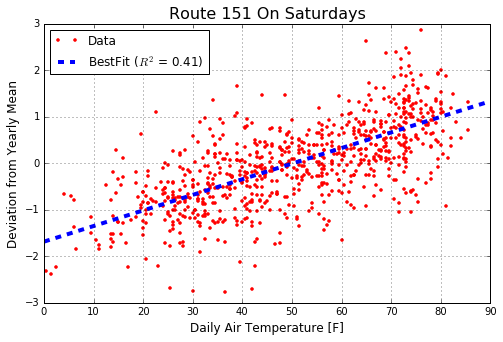

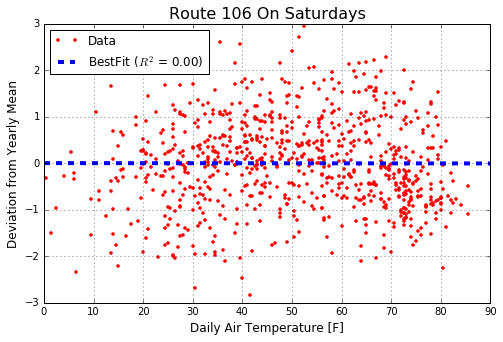

In [18]:
#ignore
for myroute in [ '151', '106' ]:
    myfig = plt.figure(figsize=(8,5))
    myquery = 'daytype == "A" and route == "%s"' % myroute
    
    myy = mergedf.query(myquery)['stds_yearmean'].values
    myx = mergedf.query(myquery)['MAXMINAVG'].values
    dummy = plt.plot(myx,myy,'r.',label='Data')
    dummy = plt.grid(True)
    
    z, residuals, rank, singular_values, rcond = polyfit(myx,myy,deg=1,full=True)
    p = np.poly1d(z)
    
    mybins = np.linspace(0,90,100)
    dummy = plt.plot(mybins,p(mybins),'b--',linewidth=4,label='BestFit ($R^2$ = %0.2f)'%resids[myroute])
    dummy = plt.legend(loc=2)
    plt.ylim((-3,3))
    plt.title('Route %s On Saturdays'%myroute,fontsize=16)
    plt.ylabel('Deviation from Yearly Mean',fontsize=12)
    plt.xlabel('Daily Air Temperature [F]',fontsize=12)
    plt.savefig('Route%sSaturdayLinearFit.png'%myroute)

Curious how I determined the most and least correlated routes? I made this plot for each route, used numpy's [polyfit](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html) package to do a least-squares polynomial fit of degree 1 (linear) and stored the resulting $R^2$ of the fit. The above two plots show that polyfit line in blue, with the $R^2$ value in the legend. Here's what the distribution of $R^2$ values look like for all of the routes.

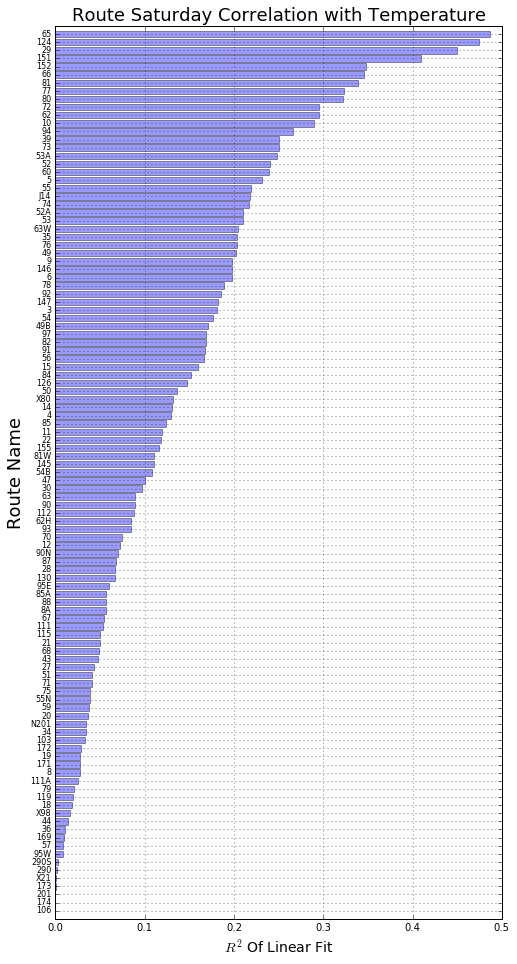

In [19]:
#ignore
#Sort the dictionary from lowest to highest R^2
#Remove NANs 
import math
for route in resids.keys():
    if math.isnan(resids[route]): resids.pop(route)
        
import operator
sorted_tuples = sorted(resids.items(), key=operator.itemgetter(1))

plt.figure(figsize=(8,16))
routes = [ x[0] for x in sorted_tuples ]
y_pos = np.arange(len(routes))
rsquares = [ x[1] for x in sorted_tuples ]

plt.barh(y_pos, rsquares, align='center', alpha=0.4)
plt.yticks(y_pos, routes,size=8)# [ x if x=='65' or x == '106' else ' ' for x in routes ]) #show a few more, big font
plt.ylim(-1,len(routes))
plt.xlabel('$R^2$ Of Linear Fit',fontsize=14)
plt.ylabel('Route Name',fontsize=18)
plt.title('Route Saturday Correlation with Temperature',fontsize=18)
plt.grid(True)

#print ['Route %s: Ridership %0.2f'%(x,ridership_dict[x]) for x in routes[-10:]]

And there you have it, a simple yet interesting example of using an SQL-like `join` command in pandas to merge together data sets from different sources. I hope you found this interesting, and perhaps educational. Thanks for reading!